In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.gridspec as gridspec
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import matplotlib.style as style
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os
print(os.listdir("house_prices_data"))

import warnings
warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

['train.csv', 'test.csv', 'sample_submission.csv', 'data_description.txt']


# A Glimpse of the datasets.
> **Sample Train Dataset**

In [2]:
## Import Trainning data. 
train = pd.read_csv("house_prices_data/train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


> ** Sample Test Dataset**

In [3]:
## Import test data.
test = pd.read_csv("house_prices_data/test.csv")
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Describe the Datasets

In [4]:
print (f"Train has {train.shape[0]} rows and {train.shape[1]} columns")
print (f"Test has {test.shape[0]} rows and {test.shape[1]} columns")

Train has 1460 rows and 81 columns
Test has 1459 rows and 80 columns


If you want to know more about why we are splitting dataset's into train and test, please check out this [kernel](https://www.kaggle.com/masumrumi/a-statistical-analysis-ml-workflow-of-titanic).

In [5]:
# gives us statistical info about the numerical variables. 
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [6]:
## Gives us information about the features. 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [7]:
## Gives use the count of different types of objects.
train.get_dtype_counts()

float64     3
int64      35
object     43
dtype: int64

## Checking for Missing Values

### Missing Train values

In [8]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_percentage(train)

,Total,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageCond,81,5.55
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55


### Missing Train values

In [9]:
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(15,10))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
    


In [10]:
#skewness and kurtosis
print("Skewness: " + str(train['SalePrice'].skew()))
print("Kurtosis: " + str(train['SalePrice'].kurt()))

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


In [11]:
## Getting the correlation of all the features with target variable. 
(train.corr()**2)["SalePrice"].sort_values(ascending = False)[1:]

OverallQual      0.625652
GrLivArea        0.502149
GarageCars       0.410124
GarageArea       0.388667
TotalBsmtSF      0.376481
1stFlrSF         0.367057
FullBath         0.314344
TotRmsAbvGrd     0.284860
YearBuilt        0.273422
YearRemodAdd     0.257151
GarageYrBlt      0.236548
MasVnrArea       0.228000
Fireplaces       0.218023
BsmtFinSF1       0.149320
LotFrontage      0.123763
WoodDeckSF       0.105244
2ndFlrSF         0.101974
OpenPorchSF      0.099765
HalfBath         0.080717
LotArea          0.069613
BsmtFullBath     0.051585
BsmtUnfSF        0.046001
BedroomAbvGr     0.028296
KitchenAbvGr     0.018471
EnclosedPorch    0.016532
ScreenPorch      0.012420
PoolArea         0.008538
MSSubClass       0.007104
OverallCond      0.006062
MoSold           0.002156
3SsnPorch        0.001988
YrSold           0.000837
LowQualFinSF     0.000656
Id               0.000480
MiscVal          0.000449
BsmtHalfBath     0.000284
BsmtFinSF2       0.000129
Name: SalePrice, dtype: float64

These are the predictor variables sorted in a descending order starting with the most correlated one **OverallQual**. Let's put this one in a scatter plot and see how it looks.

### SalePrice vs OverallQual

In [12]:
def customized_scatterplot(y, x):
        ## Sizing the plot. 
    style.use('fivethirtyeight')
    plt.subplots(figsize = (15,10))
    ## Plotting target variable with predictor variable(OverallQual)
    sns.scatterplot(y = y, x = x);

In [13]:
#customized_scatterplot(train.SalePrice, train.OverallQual)

### SalePrice vs GrLivArea

In [14]:
#customized_scatterplot(train.SalePrice, train.GrLivArea)

Let's try to keep a mental picture of each one of these charts as we go on. I will talk about all of them together. How about the next one?

### SalePrice vs GarageArea

In [15]:
#customized_scatterplot(train.SalePrice, train.GarageArea);

And the next one..?
### SalePrice vs TotalBsmtSF

In [16]:
#customized_scatterplot(train.SalePrice, train.TotalBsmtSF)

and the next ?
### SalePrice vs 1stFlrSF

In [17]:
#customized_scatterplot(train.SalePrice, train['1stFlrSF']);

How about one more...

In [18]:
#customized_scatterplot(train.SalePrice, train.MasVnrArea);

Okay, I think we have seen enough. Let's discuss what we have found so far. 

# Observations
* Our target variable shows an unequal level of variance across most predictor(independent) variable values. This is called **Heteroscedasticity(more explanation below)**; and is a red flag for the multiple linear regression model.
* There are many outliers in the scatter plots above that took my attention. 

* The two next to the top right edge of **SalePrice vs. GrLivArea** seems to follow a trend, which can be explained by saying that "As the prices increased so did the area. 
* However, The two on the bottom right of the same chart do not follow any trends. We will get rid of these two below.

In [19]:

## Deleting those two values with outliers. 
train = train[train.GrLivArea < 4500]
train.reset_index(drop = True, inplace = True)

## save a copy of this dataset so that any changes later on can be compared side by side.
previous_train = train.copy()

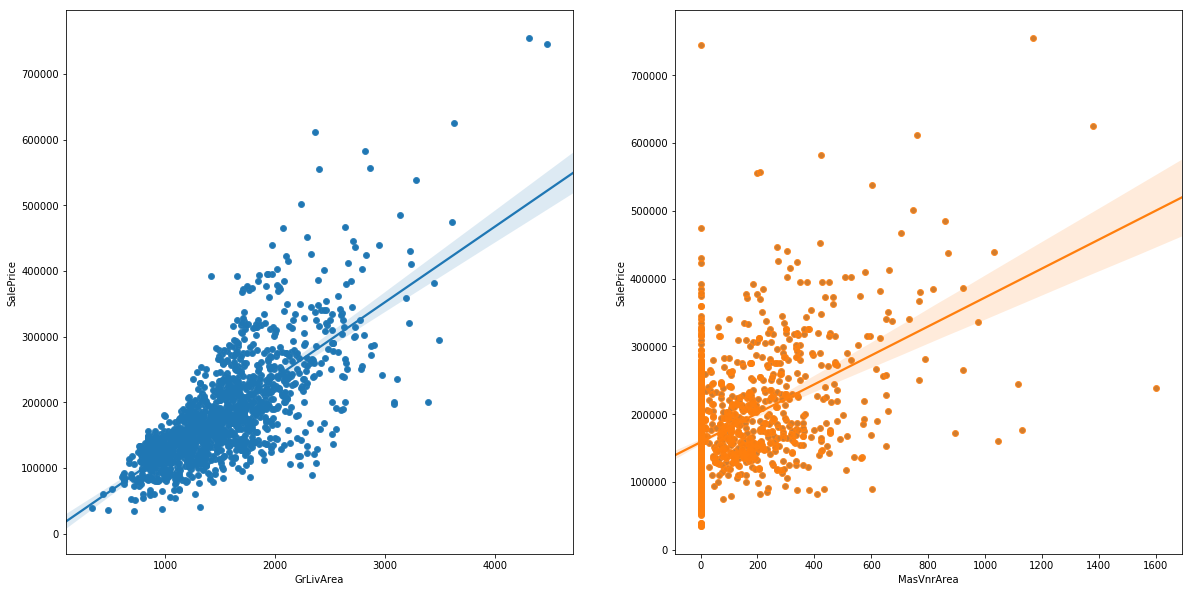

In [20]:
## Plot sizing. 
fig, (ax1, ax2) = plt.subplots(figsize = (20,10), ncols=2,sharey=False)
## Scatter plotting for SalePrice and GrLivArea. 
sns.scatterplot( x = train.GrLivArea, y = train.SalePrice,  ax=ax1)
## Putting a regression line. 
sns.regplot(x=train.GrLivArea, y=train.SalePrice, ax=ax1)

## Scatter plotting for SalePrice and MasVnrArea. 
sns.scatterplot(x = train.MasVnrArea,y = train.SalePrice, ax=ax2)
## regression line for MasVnrArea and SalePrice. 
sns.regplot(x=train.MasVnrArea, y=train.SalePrice, ax=ax2);

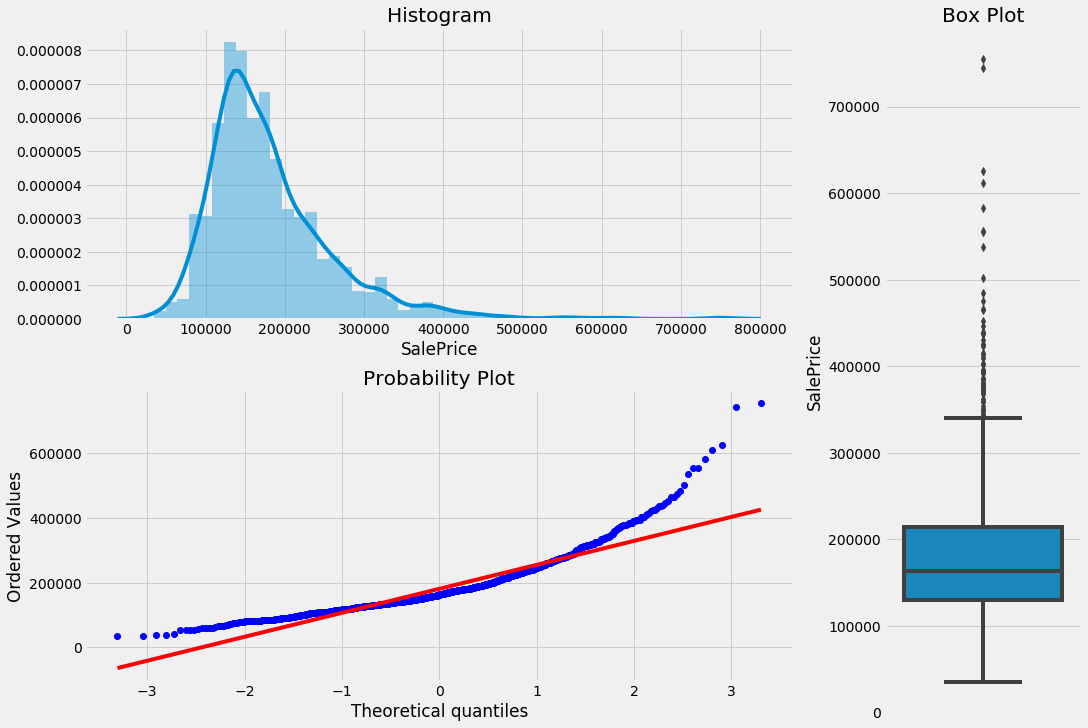

In [21]:
plotting_3_chart(train, 'SalePrice')

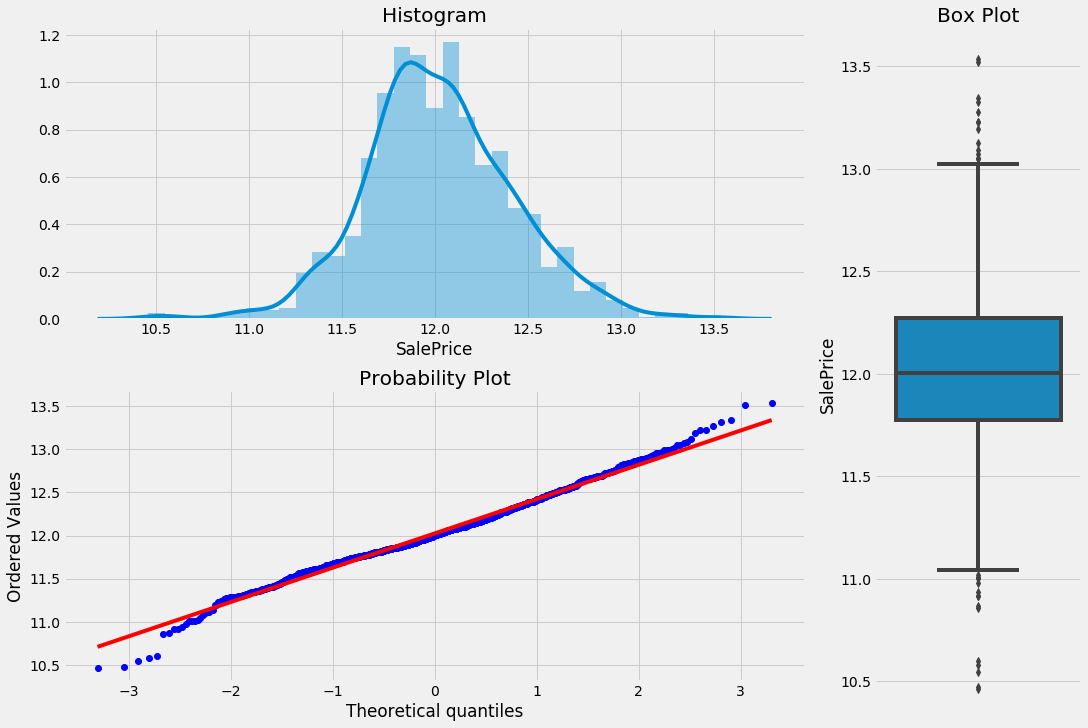

In [22]:
## trainsforming target variable using numpy.log1p, 
train["SalePrice"] = np.log1p(train["SalePrice"])

## Plotting the newly transformed response variable
plotting_3_chart(train, 'SalePrice')

As you can see the log transformation removes the normality of errors. This solves some of the other assumptions that we talked about above like Homoscedasticity. Let's make a comparison of the pre-transformed and post-transformed state of residual plots. 

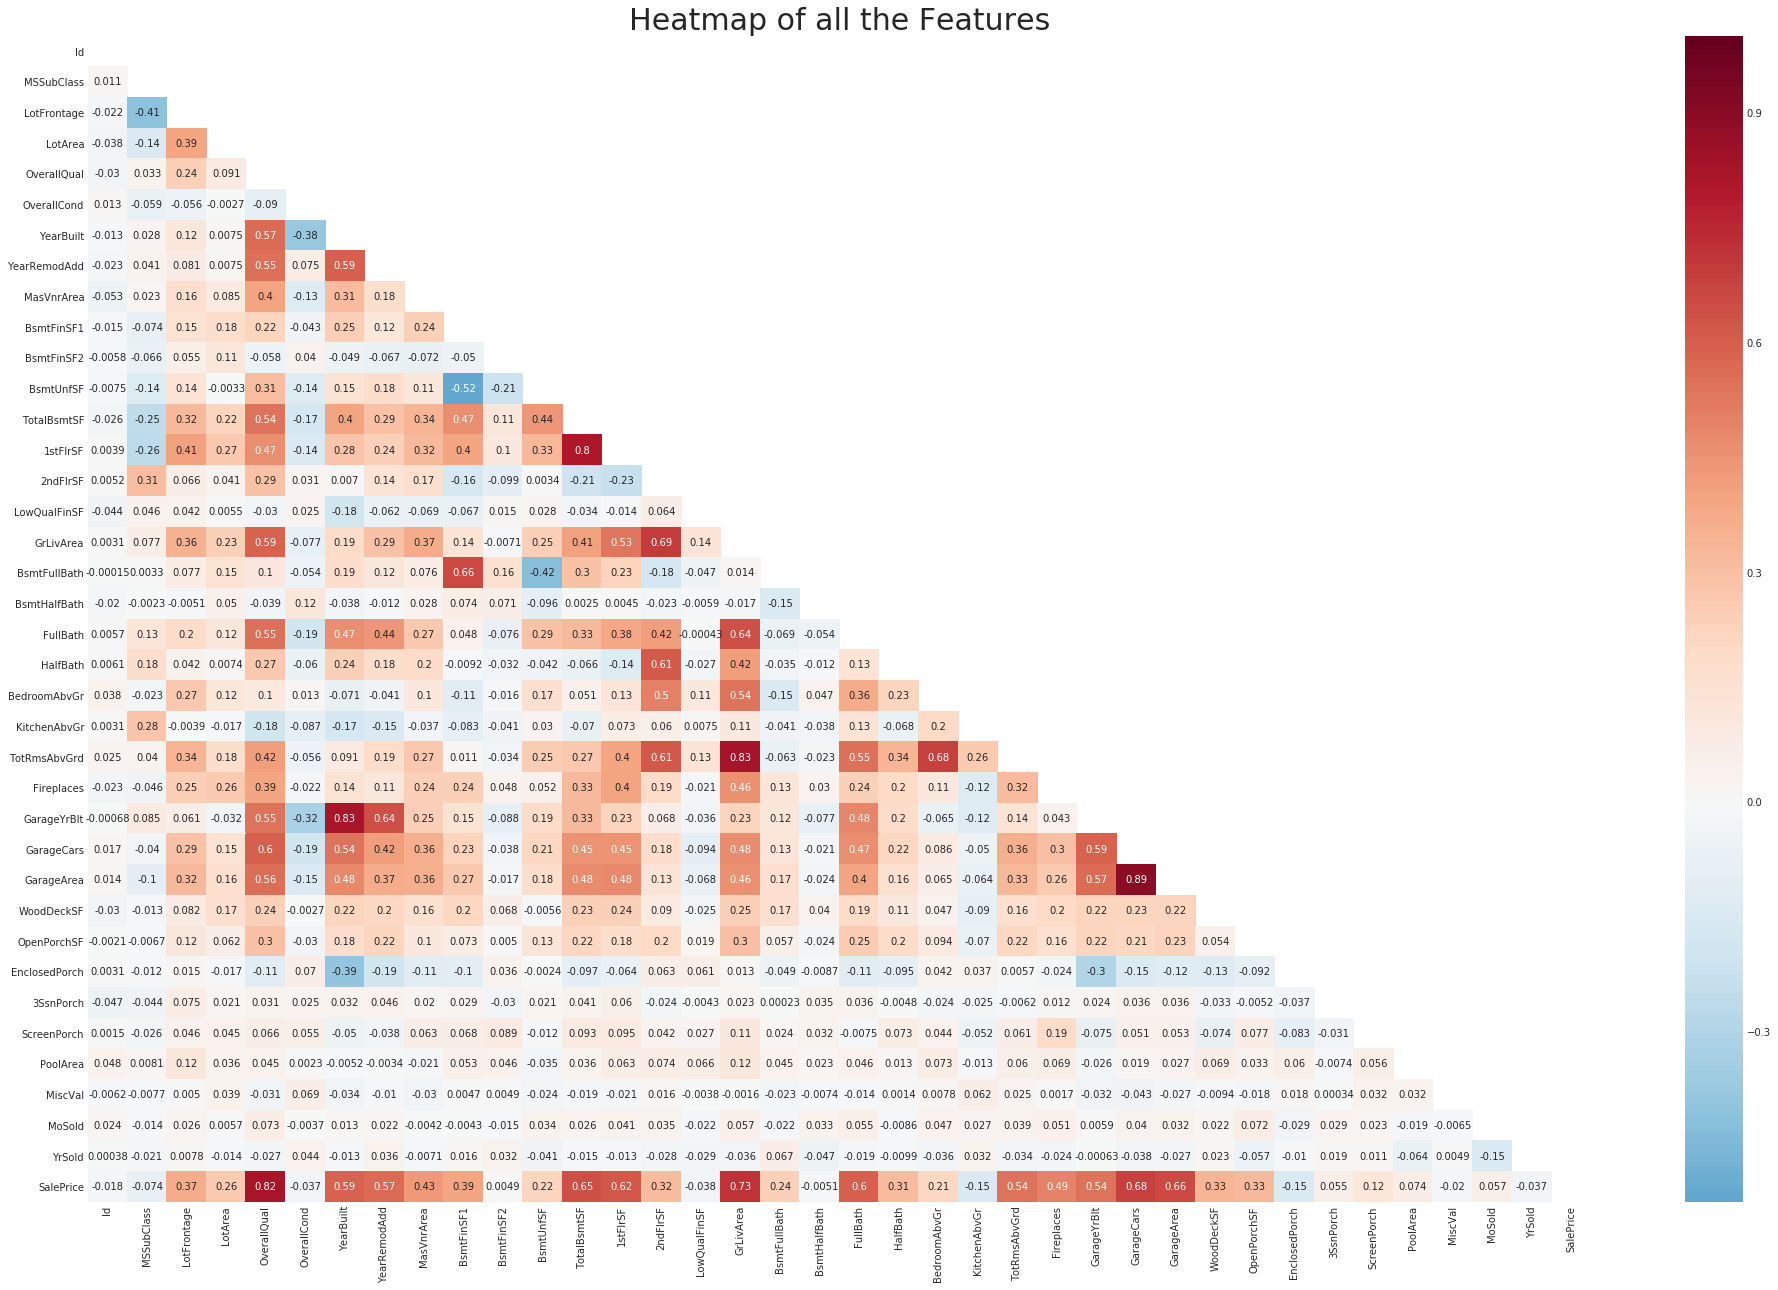

In [23]:
## Plot fig sizing. 
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,20))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(train.corr(), cmap="RdBu_r", mask = mask, annot=True, center = 0, );
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 30);

## Observation. 
As we can see, the multicollinearity still exists in various features. However, we will keep them for now for the sake of learning and lets models(e.x. Regularization models such as Lasso, Ridge) do the clean up later on. Let's go through some of the correlations that still exists. 

* There is 0.83 or 83% correlation between **GarageYrBlt** and **YearBuilt**. 
* 83% correlation between **TotRmsAbvGrd ** and **GrLivArea**. 
* 89% correlation between **GarageCars** and **GarageArea**. 
* Similarly many other features such as**BsmtUnfSF**, **FullBath** have good correlation with other independent feature but not so much with the dependent feature.

If I were using only multiple linear regression, I would be deleting these features from the dataset to fit better multiple linear regression algorithms. However, we will be using many algorithms as scikit learn modules makes it easy to implement them and get the best possible model. Therefore, we will keep all the features for now. 

<h3>Resources:</h3>
<ul>
    <li><a href="https://www.statisticssolutions.com/assumptions-of-linear-regression/">Assumptions of Linear Regression</a></li>
    <li><a href="https://www.statisticssolutions.com/assumptions-of-multiple-linear-regression/">Assumptions of Multiple Linear Regression</a></li>
    <li><a href="https://www.youtube.com/watch?v=0MFpOQRY0rw/"> Youtube: All regression assumptions explained!<a/></li>
</ul>

# Feature engineering

In [24]:
## Dropping the "Id" from train and test set. 
train.drop(columns=['Id'],axis=1, inplace=True)
test.drop(columns=['Id'],axis=1, inplace=True)


## Saving the target values in "y_train". 
y = train['SalePrice'].reset_index(drop=True)



# getting a copy of train
previous_train = train.copy()

In [25]:
all_data = pd.concat((train, test)).reset_index(drop = True)

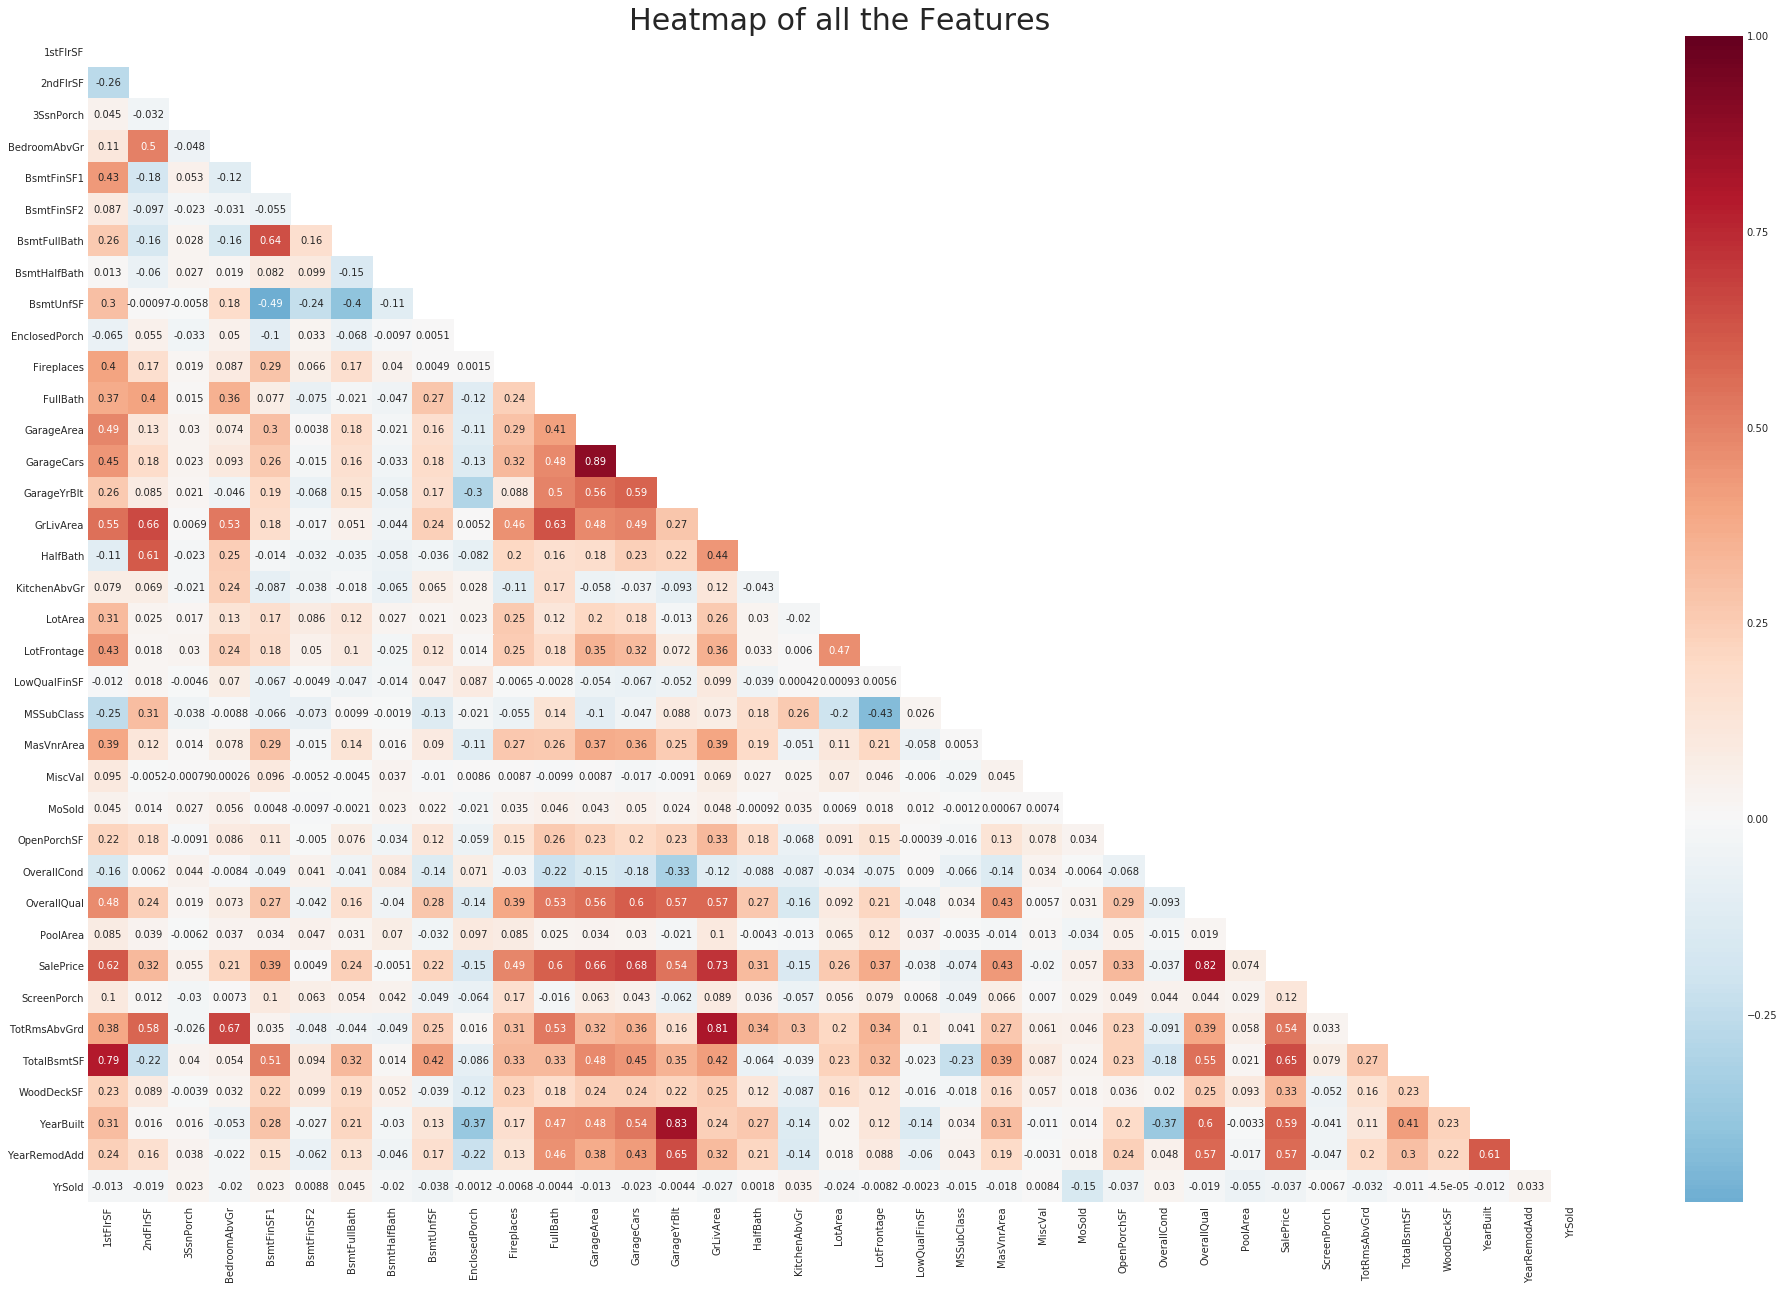

In [26]:
## Plot fig sizing. 
plt.subplots(figsize = (30,20))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(all_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(all_data.corr(), cmap="RdBu_r", mask = mask, annot=True, center = 0, );
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 30);

When we combined both train and test set, this is how the heatmap looks like.

In [27]:
quantitative = [f for f in all_data.columns if all_data.dtypes[f] != 'object']
qualitative = [f for f in all_data.columns if all_data.dtypes[f] == 'object']

def encode(df, feature, target_feature):
    """
    This function takes a dataframe, a feature(the one that should be encoded) and a target_feature(the feature that should be used for encoding)
    and returns a new feature with the original feature name + postfix(_E). 
    This new feature consists of encoded value of unique original value but the values are weighted(incremented) based on the 
    mean of target_feature and grouped by the feature itself.
    """
    ordering = pd.DataFrame()
    ordering['val'] = df[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = df[[feature, target_feature]].groupby(feature).mean()[target_feature]
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        df.loc[df[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q, 'SalePrice')
    qual_encoded.append(q+'_E')
print(qual_encoded)

['Alley_E', 'BldgType_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'BsmtQual_E', 'CentralAir_E', 'Condition1_E', 'Condition2_E', 'Electrical_E', 'ExterCond_E', 'ExterQual_E', 'Exterior1st_E', 'Exterior2nd_E', 'Fence_E', 'FireplaceQu_E', 'Foundation_E', 'Functional_E', 'GarageCond_E', 'GarageFinish_E', 'GarageQual_E', 'GarageType_E', 'Heating_E', 'HeatingQC_E', 'HouseStyle_E', 'KitchenQual_E', 'LandContour_E', 'LandSlope_E', 'LotConfig_E', 'LotShape_E', 'MSZoning_E', 'MasVnrType_E', 'MiscFeature_E', 'Neighborhood_E', 'PavedDrive_E', 'PoolQC_E', 'RoofMatl_E', 'RoofStyle_E', 'SaleCondition_E', 'SaleType_E', 'Street_E', 'Utilities_E']


In [28]:
print(train[['GarageCond','GarageCond_E']][:5])

  GarageCond  GarageCond_E
0         TA           5.0
1         TA           5.0
2         TA           5.0
3         TA           5.0
4         TA           5.0


In [29]:
## Combining train and test datasets together so that we can do all the work at once. 
all_data = pd.concat((train, test)).reset_index(drop = True)
## Dropping the target variable. 
all_data.drop(['SalePrice'], axis = 1, inplace = True)

In [30]:
all_data.shape

(2917, 122)

## Dealing with Missing Values
> **Missing data in train and test data(all_data)**

In [31]:
missing_percentage(all_data)

,Total,Percent
PoolQC_E,2911,99.79
PoolQC,2908,99.69
MiscFeature_E,2863,98.15
Alley_E,2826,96.88
MiscFeature,2812,96.40
...,...,...
BsmtUnfSF,1,0.03
Electrical,1,0.03
KitchenQual,1,0.03
BsmtFinSF2,1,0.03


> **Imputing Missing Values**

In [32]:
## Some missing values are intentionally left blank, for example: In the Alley feature 
## there are blank values meaning that there are no alley's in that specific house. 
missing_val_col = ["Alley", 
                   "PoolQC", 
                   "MiscFeature",
                   "Fence",
                   "FireplaceQu",
                   "GarageType",
                   "GarageFinish",
                   "GarageQual",
                   "GarageCond",
                   'BsmtQual',
                   'BsmtCond',
                   'BsmtExposure',
                   'BsmtFinType1',
                   'BsmtFinType2',
                   'MasVnrType']

for i in missing_val_col:
    all_data[i] = all_data[i].fillna('None')

In [33]:
## These features are continous variable, we used "0" to replace the null values. 
missing_val_col2 = ['BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'TotalBsmtSF',
                    'BsmtFullBath', 
                    'BsmtHalfBath', 
                    'GarageYrBlt',
                    'GarageArea',
                    'GarageCars',
                    'MasVnrArea']

for i in missing_val_col2:
    all_data[i] = all_data[i].fillna(0)
    
## Replaced all missing values in LotFrontage by imputing the median value of each neighborhood. 
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform( lambda x: x.fillna(x.mean()))

In [34]:
## the "OverallCond" and "OverallQual" of the house. 
# all_data['OverallCond'] = all_data['OverallCond'].astype(str) 
# all_data['OverallQual'] = all_data['OverallQual'].astype(str)

## Zoning class are given in numerical; therefore converted to categorical variables. 
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

## Important years and months that should be categorical variables not numerical. 
# all_data['YearBuilt'] = all_data['YearBuilt'].astype(str)
# all_data['YearRemodAdd'] = all_data['YearRemodAdd'].astype(str)
# all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str) 

In [35]:
all_data['Functional'] = all_data['Functional'].fillna('Typ') 
all_data['Electrical'] = all_data['Electrical'].fillna("SBrkr") 
all_data['KitchenQual'] = all_data['KitchenQual'].fillna("TA") 
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) 
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub') 

In [36]:
missing_percentage(all_data)

,Total,Percent
PoolQC_E,2911,99.79
MiscFeature_E,2863,98.15
Alley_E,2826,96.88
Fence_E,2636,90.37
FireplaceQu_E,2149,73.67
GarageCond_E,1540,52.79
GarageFinish_E,1540,52.79
GarageQual_E,1540,52.79
GarageType_E,1540,52.79
BsmtFinType2_E,1497,51.32


So, there are no missing value left. 

In [37]:
objects = []
for i in all_data.columns:
    if all_data[i].dtype == object:
        objects.append(i)
all_data.update(all_data[objects].fillna('None'))


numerics = []
for i in all_data.columns:
    if all_data[i].dtype != object:
        numerics.append(i)
all_data.update(all_data[numerics].fillna(0))

Let's see how skewed our predictor features are.

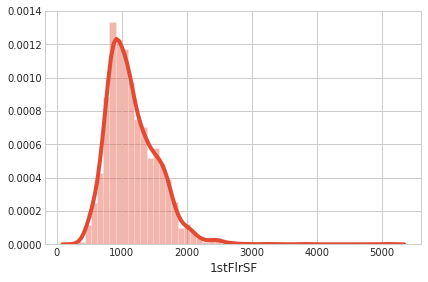

In [38]:
sns.distplot(all_data['1stFlrSF'])

In [39]:
## Fixing Skewed features using boxcox transformation. 


def fixing_skewness(df):
    """
    This function takes in a dataframe and return fixed skewed dataframe
    """
    ## Import necessary modules 
    from scipy.stats import skew
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    ## Getting all the data that are not of "object" type. 
    numeric_feats = df.dtypes[df.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index

    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))

fixing_skewness(all_data)

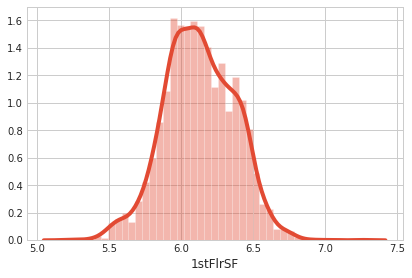

In [40]:
sns.distplot(all_data['1stFlrSF'])

In [41]:
all_data = all_data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

# feture engineering a new feature "TotalFS"
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']

all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] +
                                 all_data['1stFlrSF'] + all_data['2ndFlrSF'])

all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF'])


In [42]:
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [43]:
all_data.shape

(2917, 129)

## Creating Dummy Variables. 


In [44]:
## Creating dummy variable 
final_features = pd.get_dummies(all_data).reset_index(drop=True)
final_features.shape

(2917, 376)

In [45]:
X = final_features.iloc[:len(y), :]

X_sub = final_features.iloc[len(y):, :]

In [46]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [47]:
def overfit_reducer(df):
    """
    This function takes in a dataframe and returns a list of features that are overfitted.
    """
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.94:
            overfit.append(i)
    overfit = list(overfit)
    return overfit


overfitted_features = overfit_reducer(X)

X = X.drop(overfitted_features, axis=1)
X_sub = X_sub.drop(overfitted_features, axis=1)

In [48]:
X.shape,y.shape, X_sub.shape

((1453, 375), (1453,), (1459, 375))

# Fitting model

## Train_test split
 
We have separated dependent and independent features; We have separated train and test data. So, why do we still have to split our training data? If you are curious about that, I have the answer. For this competition, when we train the machine learning algorithms, we use part of the training set, usually two-thirds of the train data. Once we train our algorithm using 2/3 of the train data, we start to test our algorithms using the remaining data. If the model performs well, we dump our test data in the algorithms to predict and submit the competition. The code below, basically splits the train data into 4 parts, **train_x**, **test_x**, **train_y**, **test_y**.  
* **train_x** and **train_y** first used to train the algorithm. 
* then, **test_x** is used in that trained algorithms to predict **outcomes. **
* Once we get the **outcomes**, we compare it with **test_y**

By comparing the **outcome** of the model with **test_y**, we can determine whether our algorithms are performing well or not. Once we are confident about the result of our algorithm, we may use the model to on the original test data and submit in the challenge. I have tried to show this whole process in the visualization chart below.

In [49]:
## Train test s
from sklearn.model_selection import train_test_split
## Train test split follows this distinguished code pattern and helps creating train and test set to build machine learning. 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .33, random_state = 0)

In [50]:
print(X_train.shape)
print(y_train.shape)
print("*"*20)
print(X_test.shape)
print(y_test.shape)

(973, 375)
(973,)
********************
(480, 375)
(480,)


# Modeling the Data
 


As we discussed before, there is a linear relationship between SalePrice and GrLivArea. We want to know/estimate/predict the sale price of a house based on the given area, How do we do that? One naive way is to find the average of all the house prices. Let's find a line with the average of all houses and place it in the scatter plot. Simple enough.

Как мы уже говорили ранее, между SalePrice и GrLivArea существует линейная связь. Мы хотим знать / оценивать / прогнозировать цену продажи дома на основе заданной площади. Как мы это делаем? Один наивный способ - найти среднее значение всех цен на жилье. Давайте найдем линию со средним числом всех домов и разместим ее на точечной диаграмме. Достаточно просто.

In [51]:
## importing necessary models.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Call in the LinearRegression object
lin_reg = LinearRegression(normalize=True, n_jobs=-1)
## fit train and test data. 
lin_reg.fit(X_train, y_train)
## Predict test data. 
y_pred = lin_reg.predict(X_test)

In [52]:
## get average squared error(MSE) by comparing predicted values with real values. 
print ('%.2f'%mean_absolute_error(y_test, y_pred))

28482884611.12


## Using cross validation.

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
lin_reg = LinearRegression()
cv = KFold(shuffle=True, random_state=2, n_splits=10)
scores = cross_val_score(lin_reg, X,y,cv = cv, scoring = 'neg_mean_absolute_error')

In [54]:
print ('%.8f'%scores.mean())

-0.24061467


In [55]:
## Importing Ridge. 
from sklearn.linear_model import Ridge
## Assiging different sets of alpha values to explore which can be the best fit for the model. 
alpha_ridge = [-3,-2,-1,1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1,1.5, 2,3,4, 5, 10, 20, 30, 40]
temp_rss = {}
temp_mse = {}
for i in alpha_ridge:
    ## Assigin each model. 
    ridge = Ridge(alpha= i, normalize=True)
    ## fit the model. 
    ridge.fit(X_train, y_train)
    ## Predicting the target value based on "Test_x"
    y_pred = ridge.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rss = sum((y_pred-y_test)**2)
    temp_mse[i] = mse
    temp_rss[i] = rss

In [56]:
temp_mse

{-3: 4.03008341121362,
 -2: 3.2576838254266915,
 -1: 5.449515052776771,
 1e-15: 0.0123693585855982,
 1e-10: 0.012375545884670611,
 1e-08: 0.012375544342355804,
 0.0001: 0.012369962398736481,
 0.001: 0.01232567907395067,
 0.01: 0.012063871207121268,
 1: 0.013959711784100496,
 1.5: 0.01529531675359924,
 2: 0.01658308788910925,
 3: 0.0190602363484064,
 4: 0.02144498589481269,
 5: 0.02375848353874594,
 10: 0.034472963350586014,
 20: 0.05233333391179069,
 30: 0.06634484877582582,
 40: 0.07746389384560205}

In [57]:
temp_rss

{-3: 1934.4400373825383,
 -2: 1563.6882362048127,
 -1: 2615.767225332851,
 1e-15: 5.937292121087135,
 1e-10: 5.940262024641893,
 1e-08: 5.940261284330788,
 0.0001: 5.9375819513935095,
 0.001: 5.916325955496324,
 0.01: 5.790658179418206,
 1: 6.700661656368235,
 1.5: 7.34175204172763,
 2: 7.9598821867724405,
 3: 9.148913447235072,
 4: 10.293593229510101,
 5: 11.404072098598045,
 10: 16.547022408281297,
 20: 25.120000277659535,
 30: 31.84552741239639,
 40: 37.182669045888986}

In [58]:
from sklearn.linear_model import Lasso
temp_rss = {}
temp_mse = {}
for i in alpha_ridge:
    ## Assigin each model. 
    lasso_reg = Lasso(alpha= i, normalize=True)
    ## fit the model. 
    lasso_reg.fit(X_train, y_train)
    ## Predicting the target value based on "Test_x"
    y_pred = lasso_reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rss = sum((y_pred-y_test)**2)
    temp_mse[i] = mse
    temp_rss[i] = rss

In [59]:
temp_mse

{-3: 199749600926.7295,
 -2: 88777596753.9363,
 -1: 22078330820.782185,
 1e-15: 0.012653479348362084,
 1e-10: 0.012653123890333132,
 1e-08: 0.012619443594541254,
 0.0001: 0.010345561680100031,
 0.001: 0.01799353641569808,
 0.01: 0.15998234085337285,
 1: 0.16529633945001213,
 1.5: 0.16529633945001213,
 2: 0.16529633945001213,
 3: 0.16529633945001213,
 4: 0.16529633945001213,
 5: 0.16529633945001213,
 10: 0.16529633945001213,
 20: 0.16529633945001213,
 30: 0.16529633945001213,
 40: 0.16529633945001213}

In [60]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [61]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [62]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [63]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)                             

In [64]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [65]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [66]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [67]:
score = cv_rmse(ridge)
score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(gbr)
# print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

LASSO: 0.0996 (0.0145)
 2019-10-01 05:48:43.085934
elastic net: 0.0997 (0.0144)
 2019-10-01 05:49:15.626714
SVR: 0.1011 (0.0131)
 2019-10-01 05:49:25.360088
lightgbm: 0.1056 (0.0154)
 2019-10-01 05:49:38.987125
[05:49:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:49:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:44] WARNING: /worksp

In [68]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

# print('GradientBoosting')
# gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen
[05:51:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
elasticnet
Lasso
Ridge
Svr
xgboost
[05:53:26] WARNING: /workspace/src/objective/regression_

# Blending Models

In [69]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
#             (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [70]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
1.2042284072896448


In [71]:
print('Predict submission')
submission = pd.read_csv("house_prices_data/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

Predict submission


In [72]:
print('Blend with Top Kernels submissions\n')
sub_1 = pd.read_csv('../input/top10stackingmicebrutalforce/House_Prices_submit.csv')
sub_2 = pd.read_csv('../input/hybridsvmbenchmarkapproach/hybrid_solution.csv')
sub_3 = pd.read_csv('../input/lassomodelforregressionproblem/lasso_sol22_Median.csv')
submission.iloc[:,1] = np.floor((0.25 * np.floor(np.expm1(blend_models_predict(X_sub)))) + 
                                (0.25 * sub_1.iloc[:,1]) + 
                                (0.25 * sub_2.iloc[:,1]) + 
                                (0.25 * sub_3.iloc[:,1]))

Blend with Top Kernels submissions



FileNotFoundError: [Errno 2] File b'../input/top10stackingmicebrutalforce/House_Prices_submit.csv' does not exist: b'../input/top10stackingmicebrutalforce/House_Prices_submit.csv'

# Submission

In [ ]:
q1 = submission['SalePrice'].quantile(0.005)
q2 = submission['SalePrice'].quantile(0.995)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission.csv", index=False)